<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.
* Métodos de *kernel*.
* Extracción de características.
* Múltiples anotaciones

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de discusión y entrega: 8 de Noviembre.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF393-II-2019]

<hr style="height:2px;border:none"/>

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Sentiment Analysis en Texto  
[2.](#segundo) pendiente


<a id="primero"></a>
## 1. Sentiment Analysis en Texto

El análisis de emociones o sentimientos se refiere al proceso de extraer información acerca de la actitud
que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con respecto a un
tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar la polaridad
de un trozo de texto, es decir, clasificar una determinada evaluación escrita (*review*), en que una persona
manifiesta una opinión, como *positiva*, *negativa* o *neutral*. Esto también ha sido extendido a otros medios, como lo es analizar la polaridad de textos en redes sociales.  La dificultad de este problema radica en el carácter altamente ambiguo e informal del lenguaje que utilizan naturalmente las personas ası́ como el manejo de negaciones, sarcasmo y abreviaciones en una frase.

<img src="https://formtitanhelpdeskimage.s3.amazonaws.com/70c78f9df2fd5c130e7021644f78f4c5.jpg" title="Title text" width="40%" />


Los datos que usaremos para esta actividad corresponden a un subconjunto de los datos publicados en **Kaggle**,  en  el  contexto  de  una  competencia  organizada  por  la  Universidad  de  Stanford  [[2]](#refs).   Cada  registro disponible corresponderá a una opinión sobre una película, registrada sobre el sitio *Rotten Tomatoes*.  Para empezar  nos  limitaremos  a  estudiar  textos  anotados  como  positivos  o  negativos,  clases  que  codificaremos como +1 y 0 respectivamente. Los datos pueden ser descargados ejecutando el siguiente código en sistema Unix:
```
wget -O train_data.csv http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train
wget -O test_data.csv http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev
```

> Cargue los dos conjuntos de datos a ser trabajados, donde la etiqueta ya viene codificada y la dejaremos como negativo (0) y positivo (1).


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
##
from sklearn.model_selection import train_test_split
##
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
##
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
##

In [2]:
ftr = open("./train_data.csv", "r",  encoding="ISO-8859-1")
rows = [line.split(" ",1) for line in ftr.readlines()]

# Train Dataset
df_train = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_train['Sentiment'] = (pd.to_numeric(df_train['Sentiment'])+1)/2 # 0 o 1

ftr = open("./test_data.csv", "r",  encoding="ISO-8859-1")
rows = [line.split(" ",1) for line in ftr.readlines()]

# Test Dataset
df_test = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_test['Sentiment'] = (pd.to_numeric(df_test['Sentiment'])+1)/2 # 0 o 1

In [3]:
df_train_text = df_train.Text
df_test_text = df_test.Text
labels_train = df_train.Sentiment.values
labels_test = df_test.Sentiment.values


> a) Describa los datos trabajados, como la cantidad de datos en cada conjunto, largo de los textos, la cantidad de ejemplo por cada clase, o alguna otra forma que piense que pueda ser útil para comprender el problema trabajado.

Dataset de  entrenamiento
------------------------
Total de datos 3554
Cantidad de datos positivos:  1770
Cantidad de datos etiquetados negativamente:  1784


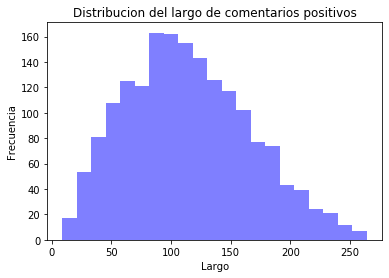

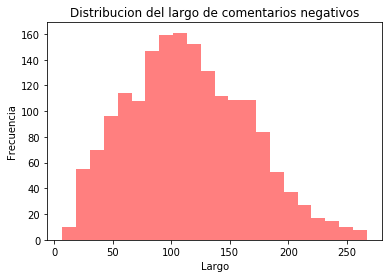

Dataset de  prueba
------------------------
Total de datos 3554
Cantidad de datos positivos:  1751
Cantidad de datos etiquetados negativamente:  1803


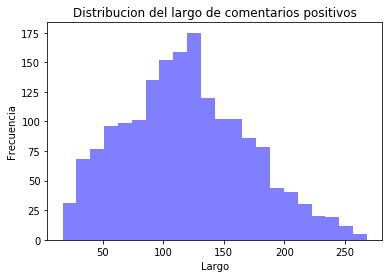

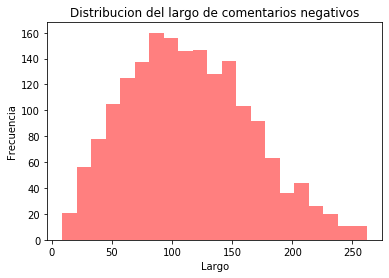

In [4]:
def stats_info(dataframe, label):
    data_count = dataframe.count()[0]
    positives_count = dataframe[dataframe.Sentiment == 1].count()[0]
    negatives_count = dataframe[dataframe.Sentiment == 0].count()[0]

    print("Dataset de ", label)
    print("------------------------")
    print("Total de datos", data_count)
    print("Cantidad de datos positivos: ", positives_count)
    print("Cantidad de datos etiquetados negativamente: ", negatives_count)

    positive_text_lenghts = []
    negative_text_lenghts = []

    for i in range(data_count):
        text = len(dataframe.Text[i])

        if dataframe.Sentiment[i] == 0:
            negative_text_lenghts.append(text)

        else:
            positive_text_lenghts.append(text)

    plt.hist(positive_text_lenghts, alpha=0.5, bins = "auto", color='blue')
    plt.title("Distribucion del largo de comentarios positivos")
    plt.xlabel('Largo')
    plt.ylabel('Frecuencia')
    plt.show()

    plt.hist(negative_text_lenghts, alpha=0.5, bins = "auto", color='red')
    plt.title("Distribucion del largo de comentarios negativos")
    plt.xlabel('Largo')
    plt.ylabel('Frecuencia')
    plt.show()

stats_info(df_train, "entrenamiento")
stats_info(df_test, "prueba")

**Comentarios:** Los histogramas mostrados corresponden a la distribucion del largo de palabras por cada clase. Se puede observar que en ambos tienden a una distribución normal con sesgos hacia la izquierda; lo significa que el largo de los textos puede ser una característica interesante para analizar.

> b) Construya un conjunto de validación desde el conjunto de entrenamiento para seleccionar modelos. Decida el tamaño dada la cantidad de ejemplos que se tienen para entrenamiento.


In [5]:
df_train_text, df_val_text, labels_train, labels_val  = train_test_split(df_train_text, labels_train, test_size=0.2, random_state=0)

**Comentarios:** Se decidió usar una proporción del 20% respecto a los datos de entrenamiento ya que es una práctica común en el área; además, se desea mantener un 60% de entrenamiento, 20% de validación y 20% de pruebas.


> c) Realice un pre-procesamiento a los textos para normalizar un poco su estructura, para ello utilice el código de ejemplo a continuación, donde se pasa el texto a minúsculas (*lower-casing*), se reducen las mútliples letras, se eliminan palabras sin significados como artículos, pronombres y preposiciones (*stop word removal* [[3]](#refs)), además de pasar las palabras a su tronco léxico con la técnica de *lemmatizer* [[4]](#refs). Comente la importancia de un correcto pre-procesamiento en el domino de lenguaje natural.

In [6]:
#Se corre solo una vez
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Seba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Seba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Seba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 

def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words


texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]

**Comentarios:** Realizar un pre-procesamiento correcto es un paso muy importante ya que permite transformar textos en algo que los algoritmos pueden usar para procesos complejos a través de sus 4 etapas. 

*   La *limpieza* permite descartar información innecesaria como mayúsculas, caracteres y otros detalles no relevantes. 
*   Las *anotaciones* etiquetan los datos, lo que permite a los modelos reconocer patrones recurrentes.
*   La *normalización* mapea los términos con el fin de reducir la redundancia.
*   Un *análisis* mediante pruebas, manipulación y generalización para el análisis características.

En este caso ésta técnica facilitará y mejorará los resultados de los siguientes procesamientos porque hay palabras que se repiten innecesariamente y hacen que los textos pierdan su simplicidad. Por ejemplo, una opinión podría ser explicada bien con pocas y simples palabras, en vez de caer en redundancias.

La importancia del pre-procesamiento radica principalmente en reducir aquellos elemento que no entregan o entregan poca información semántica, por ejemplo el uso de mayúsculas o algunos tokens, tambien existen palabras que se repiten varias veces en los textos y por lo mismo aportan poco valor semantico, estas palabras son conocidas como stop words y con el preprocesamiento son quitadas.


> d) Construya una representación vectorial a los textos de entrada para poder ser manejados y clasificados por los modelos de aprendizaje. Para ésto utilice el tipo de característica más común, que consiste en contar cuántas veces aparece cada términos/palabras en el texto, denominado **TF** (*term-frequency*). Para esto, se necesita contar con un vocabulario base, el cual se construirá a través de la unión de todas las palabras que observemos en los textos de entrenamiento ¿Cuáles son las palabras más frecuentes?

**Conjunto de entrenamiento**

<BarContainer object of 20 artists>

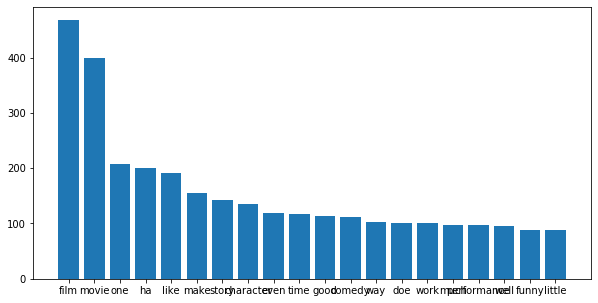

In [8]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation

vectorizer.fit(texts_train)
features_train = vectorizer.transform(texts_train)

vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

frec = sorted(list(zip(vocab, dist)),key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10,5))
#plt.bar(list(zip(*frec))[0],list(zip(*frec))[1]) #para ver todas las frecuencias
plt.bar(list(zip(*frec[:20]))[0],list(zip(*frec[:20]))[1]) #para ver los 20 más frecuentes

**Comentarios:** Se puede observar las palabras *film*, *movie* y *one* como las 3 palabras más frecuentes, lo que tiene sentido debido a la temática que se está analizando. Además se pueden ven verbos como *like* (seguramente en contexto de gustar) y adjetivos como *funny* que deben acompañar a las palabras principales.

**Conjunto de validación**

<BarContainer object of 20 artists>

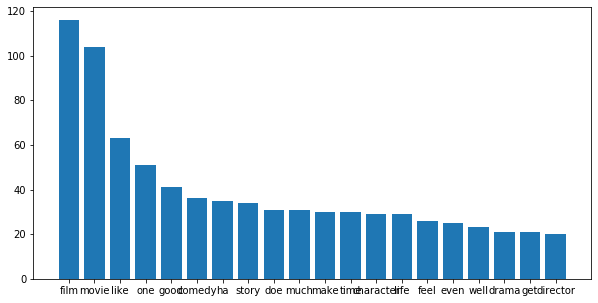

In [9]:
features_val = vectorizer.transform(texts_val)

vocab = vectorizer.get_feature_names()
dist=list(np.array(features_val.sum(axis=0)).reshape(-1,))

frec = sorted(list(zip(vocab, dist)),key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10,5))
#plt.bar(list(zip(*frec))[0],list(zip(*frec))[1]) #para ver todas las frecuencias
plt.bar(list(zip(*frec[:20]))[0],list(zip(*frec[:20]))[1]) #para ver los 20 más frecuentes

**Comentarios:** Al igual que el conjunto de entrenamiento, se observan las palabras *film* y *movie* como las más frecuentes. En el resto menos frecuente se pueden observar palabras asociadas al contexto anterior, tales como: *comedy*, *story* y *drama*.

**Conjunto de prueba**


<BarContainer object of 20 artists>

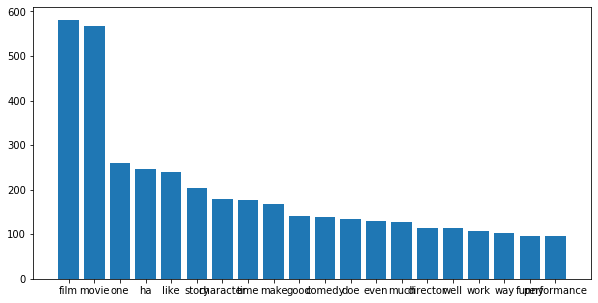

In [10]:
features_test = vectorizer.transform(texts_test)

vocab = vectorizer.get_feature_names()
dist=list(np.array(features_test.sum(axis=0)).reshape(-1,))

frec = sorted(list(zip(vocab, dist)),key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10,5))
#plt.bar(list(zip(*frec))[0],list(zip(*frec))[1]) #para ver todas las frecuencias
plt.bar(list(zip(*frec[:20]))[0],list(zip(*frec[:20]))[1]) #para ver los 20 más frecuentes

**Comentarios:** Al igual que los otros dos conjuntos, las palabras *film* y *movie* son las más frecuentes. En general en todos los conjuntos se puede asociar a una distribución en común, lo que es positivo para entrenar modelos.

> e) Para tener una visión distinta y entender mejor la representación vectorial realizada, visualice los datos en un plano 2D. Para ésto utilice la técnica **LSA** (*Latent Semantic Analysis*) [[5]](#refs) que a diferencia de PCA, **no centra** los datos antes de realizar la descomposicipon SVD, de ésta manera podrá visualizar el espacio semántico de "conceptos" latentes usados en la representación. Coloree cada texto en base a su clase ¿Qué indica lo observado? Comente e interprete los resultados

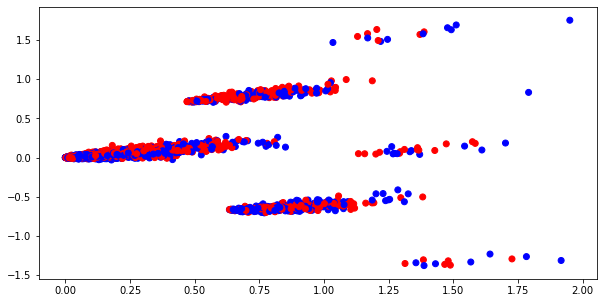

In [11]:
from sklearn.decomposition import TruncatedSVD

model = TruncatedSVD(n_components=2)
model.fit(features_train)
x_plot = model.transform(features_train)

labels_train_int = labels_train.astype(int)
colormap = np.array(['r', 'b'])

plt.figure(figsize=(10,5))
plt.scatter(x_plot[:,0], x_plot[:,1], c=colormap[labels_train_int])
plt.show()


**Comentarios:** La ilustración anterior muestra clusters de los registros del dataset en 2D. Aquellos puntos azules corresponden a sentencias marcadas como positivas; mientras las rojas, negativas. Se pueden diferenciar facilmente tres cluster y si consideramos la cercanía de puntos como la similitud semántica, se puede deducir que los comentarios positivos que se encuentran mas alejados tienen texto y contenido muy diferente al resto.



> f) Entrene un modelo de Regresión Logística Regularizado (utilizando como penalizador la norma $l_2$). Varíe el parámetro de regularización $C$, en potencias de 10, midiendo el error de predicción obtenido sobre los datos de entrenamiento y validación, construya un gráfico que muestre la variación de ambos errores respecto al parámetro $C$. Explique el significado y valor esperado del parámetro de regularización.


C:\Users\Seba\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Seba\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

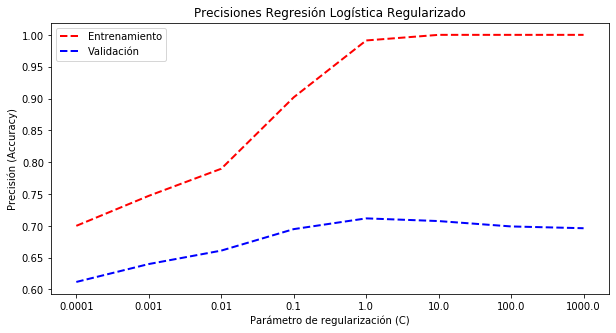

El mejor accuracy es 0.7116736990154712 cuando C = 1.0


In [12]:
from sklearn.linear_model import LogisticRegression

def do_LOGIT(x, y, xv, yv, param):
    #print("Param C = ", param)
    model = LogisticRegression()
    model.set_params(C = param)
    model.fit(x, y)
    train_acc = model.score(x, y)
    test_acc = model.score(xv, yv)

    return model, train_acc, test_acc

def logit_plot():
  train_accs = []
  test_accs = []
  max_val_acc = 0
  C = 0
  Cs = [10**i for i in np.arange(-4,4).astype(float)]

  for i in Cs:
    model, train_acc, test_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = i)

    if test_acc > max_val_acc:
      max_val_acc = test_acc
      C = i

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
  plt.figure(figsize=(10,5))
  plt.plot(train_accs, marker='', color='red', linewidth=2, linestyle='dashed', label="Entrenamiento")
  plt.plot(test_accs, marker='', color='blue', linewidth=2, linestyle='dashed', label="Validación")
  xi = list(range(len(Cs)))
  plt.xticks(xi, Cs)
  plt.title('Precisiones Regresión Logística Regularizado')
  plt.legend()
  plt.xlabel('Parámetro de regularización (C)')
  plt.ylabel('Precisión (Accuracy)')
  plt.show()

  print("El mejor accuracy es {} cuando C = {}".format(max_val_acc, C))

logit_plot()

**Comentarios:** Se puede observar como ambas precisiones aumentan a medida que el parámetro de regularización se vuelve más fuerte, es decir, se van eliminando atributos irrelevantes. Una idea general es que el modelo elimina aquellos atributos que no son relevantes para clasificar una opinión como positiva o negativa, esto puede estar relacionado con las palabras que no se eliminaron en el pre-procesamiento.

El conjunto de entrenamiento permite analizar que tanto overfitting se está produciendo. En este caso, ambos conjuntos tienen un comportamiento similar entre C = 0.0001 y C = 1.0 lo que significa un comportamiento positivo porque no hay overfitting; sin embargo, luego del intervalo anterior el conjunto de validación tiende a encontrar más errores de predicción mientras el conjunto de entrenamiento no, evidenciando así un overfitting casi despreciable.

En general este modelo entrega resultados positivos para poder ser considerado. Podría servir para determinar cuales son los mejores atributos de entrada y poder hacer más pruebas. Además, en base a los resultados obtenidos se podría asumir que los atributos no están tan correlacionados.


> g) Entrene una Máquina de Soporte Vectorial (SVM) con distintos kernels. Similar a lo anterior, construya un gráfico que muestre la variación de ambos errores respecto al parámetro de regularización $C$ para cada tipo de kernel que experimente. Explique el significado y valor esperado de los parámetros en este modelo.



In [13]:
from sklearn.svm import SVC as SVM #SVC is for classification

def do_SVM(x, y, xv, yv, param, kernel_choice):
    C = param
    #print("Param C= ",C, 'Kernel= ', kernel_choice)
    model= SVM(kernel = kernel_choice)
    model.set_params(C = C, kernel = kernel_choice) #try rbf and linear at least
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)

    return model, train_acc, test_acc

def kernels_plot(kernel):
  Cs = [10**i for i in np.arange(-4,4).astype(float)]
  list_train = list()
  list_test  = list()
  max_val_acc = 0
  C = 0

  for i in Cs:
      model, train_acc, test_acc = do_SVM(features_train, labels_train, features_val, labels_val, i, kernel)
      list_train.append(train_acc)
      list_test.append(test_acc)

      if test_acc > max_val_acc:
        max_val_acc = test_acc
        C = i 

  plt.plot(list_train, marker='', color='red', linewidth=2, linestyle='dashed', label="Entrenamiento")
  plt.plot(list_test, marker='', color='blue', linewidth=2, linestyle='dashed', label="Validación")
  xi = list(range(len(Cs)))
  plt.xticks(xi, Cs)
  plt.title("Precisiones SVM, Kernel: " + kernel)
  plt.legend()
  plt.xlabel('Parámetro de regularización (C)')
  plt.ylabel("Precisión (Accuracy)")
  plt.show()

  print("El mejor accuracy es {} cuando C = {}".format(max_val_acc, C))

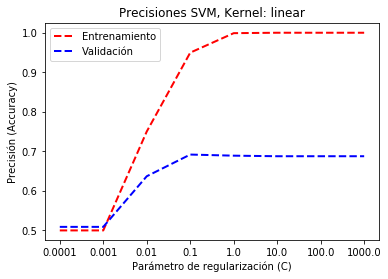

El mejor accuracy es 0.6919831223628692 cuando C = 0.1


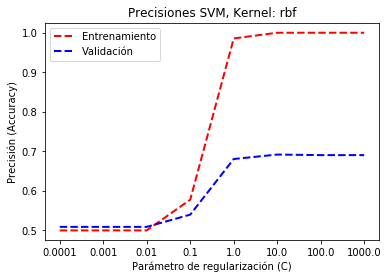

El mejor accuracy es 0.6919831223628692 cuando C = 10.0


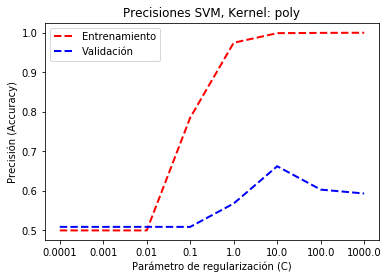

El mejor accuracy es 0.6624472573839663 cuando C = 10.0


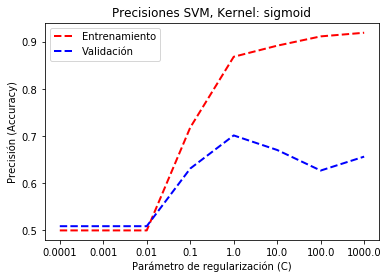

El mejor accuracy es 0.7018284106891702 cuando C = 1.0


In [14]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

kernels_plot("linear")
kernels_plot("rbf")
kernels_plot("poly")
kernels_plot("sigmoid")
# kernels_plot("precomputed")

**Comentarios**: Lo que hace SVM es construir un hiperplano de n dimensiones (donde n es la cantidad de atributos) para clasificar los datos. En este caso se está construyendo hiperplano que pueda separar adecuadamente los puntos etiquetados como positivos o negativos. Sin embargo, pueden existir puntos que traspasen la frontera a la cual pertenecen; es ahí donde entra en juego el valor de C. El parámetro de regularización se encarga de ajustar un margen al hiperplano capaz de ignorar puntos dentro de éste. A medida que C aumenta, menor será este margen y una menor cantidad de puntos serán ignorados. Por tanto se esperaría los accuracies aumenten a medida que C lo hace, lo que se puede comprobar observando los gráficos anteriores.

En relación a los gráficos:

*  Con kernel *linear* ambas precisiones tienen un comportamiento similar a medida que *C* aumenta, terminando con un accuracy final de 0.692. No se evidencia overfitting.
*  El kernel *rbf* tiene un ajuste tardío en comparación al anterior, pero que termina con un accuracy de 0.692.
*  El kernel *poly* tiene un comportamiento interesante, ya que hasta que C = 10, los comportamientos son similares, pero luego de ete valor, el accuracy del conjunto de validación disminuye a medida que el del conjunto de entrenamiento se mantiene constante, lo que podría significar un leve overfitting. Su accuracy máximo es de 0.662 aproximadamente. Una razón de este fenómeno puede ser que el hiperplano trazado está muy lejos de los puntos y ni aumentando el margen se logra alcanzarlos.
*  El kernel *sigmoid* tiene un comportamiento parecido al *poly* pero sus accuracies aumentan antes y más rapido, logrando una precisión máxima mayor de 0.702 aproximadamente. Luego, al igual que el otro kernel, despues de C = 1 la precisión del conjunto de validación decrece mientras el de entrenamiento aumenta, lo que evidencia overfitting. Esto se regula despues de C = 100.

Finalmente, los resultados son positivos, siendo la SVM con kernel sigmoid y C = 10 una buena opción para considerar para problemas de esta índole.

> h) Utilice el algoritmo de similaridad k-NN para intentar resolver el problema. Varíe el parámetro de los vecinos $k$ en un rango que estime conveniente y realice graficos de errores como en las preguntas anteriores. Comente sobre el valor esperado de este parámetro.

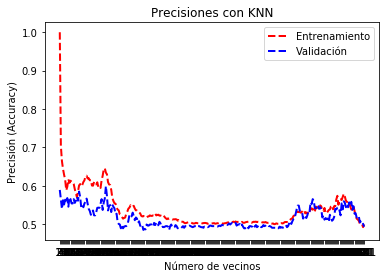

El mejor accuracy es 0.5991561181434599 cuando k = 431


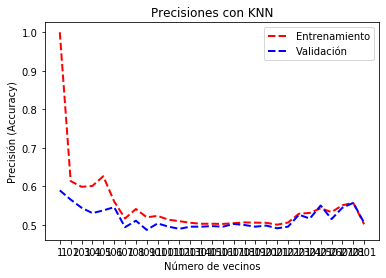

El mejor accuracy es 0.5893108298171589 cuando k = 1


In [15]:
from sklearn.neighbors import KNeighborsClassifier

def do_KNN(x, y, xv, yv, param):
    model = KNeighborsClassifier()
    #print("Param K= ",param)
    model.set_params(n_neighbors = param)
    model.fit(x, y)
    train_acc = model.score(x, y)
    test_acc = model.score(xv, yv)

    return model, train_acc, test_acc

def knn_plot(steps = 100):
  train_accs = []
  test_accs = []
  Ks = np.arange(1, features_train.shape[0], steps)
  max_val_acc = 0
  k = 0

  for i in Ks:
    model, train_acc, test_acc = do_KNN(features_train, labels_train, features_val, labels_val, param = i)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc > max_val_acc:
      max_val_acc = test_acc
      k = i
    
  plt.plot(train_accs, marker='', color='red', linewidth=2, linestyle='dashed', label="Entrenamiento")
  plt.plot(test_accs, marker='', color='blue', linewidth=2, linestyle='dashed', label="Validación")
  xi = list(range(len(Ks)))
  plt.xticks(xi, Ks)
  plt.legend()
  plt.xlabel('Número de vecinos')
  plt.ylabel('Precisión (Accuracy)')
  plt.title("Precisiones con KNN")
  plt.show()

  print("El mejor accuracy es {} cuando k = {}".format(max_val_acc, k))

knn_plot(10)
knn_plot(100)

**Comentarios:** Lo que hace KNN es calcular una distancia entre los items a clasificar y el resto de items del dataset de entrenamiento. Para ello se seleccionan los *k* elementos más cercanos (vecinos) y se escoge aquella clase que domine en esa zona para decidir la clasificación final. Entonces, al aumentar *k* no es posible predecir como influirá en los accuracies, pues depende de los elementos que existan en vecindades. 

Para medir los accuracies, se recorrieron los elementos en intervalos de 10 y 100.

De los gráficos se puede apreciar un comportamiento bastante irregular en las precisiones, donde ambos parecieran ilustrar la misma forma: una disminución irregular al inicio, una forma constante y luego un aumento irregular. Sin embargo es algo esperado, ya que como se dijo anteriormente, aumentar la cantidad de vecinos a considerar depende de los datos que existan.
Otra cosa que se podía esperar es que el mejor accuracy se logra cuando k = 1, ya que con este valor se están considerando todos los datos individualmente como el mejor (no hay comparación con vecinos). De todos modos es un resultado positivo para el overfitting, ya que el comportamiento similar implicaría la ausencia de éste.

Considerando la precisión máxima lograda por el conjunto con más vecinos se puede decir que es un valor bajo y que no supera a los modelos anteriores. 


> i) Entrene un Arbol de Decisión para resolver el problema. Varíe los parámetros de *max depth* y *min samples split* de manera separada, constuyendo gráficos de error respecto a estos parámetros. *Los valores que se presentan son sugerencias, no es necesario utilizar los mismos*. Comente sobre la diferencia entre la selección de estos dos parámetros.



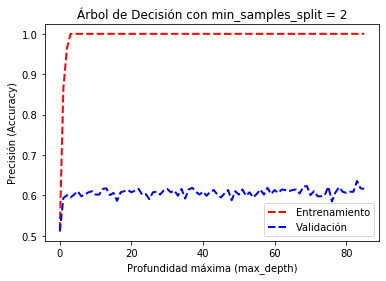

El mejor accuracy es 0.6357243319268636 cuando max_depth = 8301


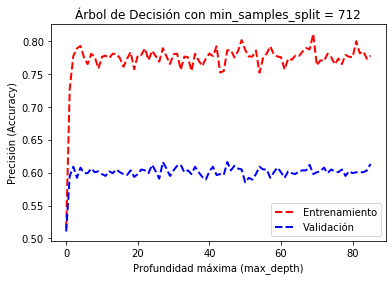

El mejor accuracy es 0.6160337552742616 cuando max_depth = 2701


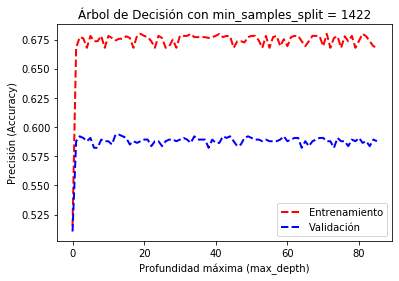

El mejor accuracy es 0.5935302390998594 cuando max_depth = 1201


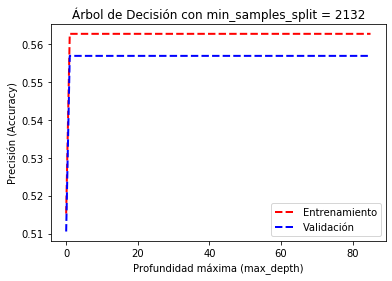

El mejor accuracy es 0.5569620253164557 cuando max_depth = 101


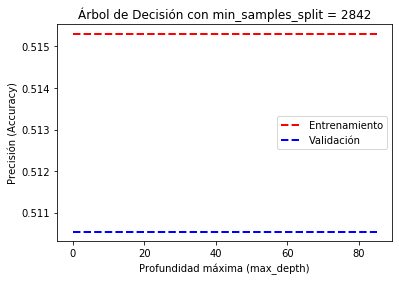

El mejor accuracy es 0.510548523206751 cuando max_depth = 1


In [16]:
from sklearn.tree import DecisionTreeClassifier as Tree

# Explicación: https://scikit-learn.org/stable/modules/tree.html
def do_Tree(x, y, xv, yv, param_d = None, param_m = 2):
    model= Tree()
    #print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth = param_d, min_samples_split = param_m) 
    model.fit(x, y)
    train_acc = model.score(x, y)
    test_acc = model.score(xv, yv)

    return model, train_acc, test_acc

def tree_plot(depths, samples):
  train_accs = []
  test_accs = []
  max_val_acc = 0
  best_depth = 0

  for depth in depths:
    model, train_acc, test_acc = model, train_acc, test_acc = do_Tree(features_train, labels_train, features_val, labels_val, depth, samples)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc > max_val_acc:
      max_val_acc = test_acc
      best_depth = depth
  
  plt.plot(train_accs, marker='', color='red', linewidth=2, linestyle='dashed', label="Entrenamiento")
  plt.plot(test_accs, marker='', color='blue', linewidth=2, linestyle='dashed', label="Validación")
  #xi = list(range(len(depths)))
  #plt.xticks(xi, Cs)
  plt.title("Árbol de Decisión con min_samples_split = " + str(samples))

  plt.legend()
  plt.xlabel('Profundidad máxima (max_depth)')
  plt.ylabel('Precisión (Accuracy)')
  plt.show()

  print("El mejor accuracy es {} cuando max_depth = {}".format(max_val_acc, best_depth))
  

Depths = np.arange(1, features_train.shape[1], 100 ) #choose steps
SamplesS = np.arange(2, features_train.shape[0] , int(features_train.shape[0]/4)) #choose steps

for samples in SamplesS:
  tree_plot(Depths, samples)

**Comentarios:** En este caso se variaron los parámetros de forma separada. Los samples se divieron en 4 partes equitativas, donde por cada valor se entrenaron árboles de decisión variando los max_depth en intervalos de 100 entre la cantidad de atributos para entrenamiento.

Con respecto a los resultados:

*   Con min_samples_split = 2 el comportamiento de las precisiones para el conjunto de validación pareciera tener un comportamiento irregular pero que tiende a ser constante. Lo que está ocurriendo aquí es que el modelo sufre de *overfit*, lo que se puede comprobar con el comportamiento de las precisiones en el conjunto de pruebas, ya que tiene precisión 1 en todo momento. El máximo accuracy que logra es aproximadamente de 0.636 cuando max_depth = 8301, lo que no supera los modelos anteriores.
*   El resto de los resultados no parecieran mejorar, aunque se reduce el overfitting. Lo anterior se debe a que al árbol le cuesta aprender de los datos, lo que resulta en una baja calidad del modelo.

Existen otras razones del comportamiento del modelo, como por ejemplo la cantidad de atributos que también pueden significar overfit cuando hay pocos samples. Los resultados se podrían mejorar si se estudian los atributos (PCA o ICA pueden ser buenas alternativas).

En conclusión, la profundidad del árbol mejora el accuracy; mientras que la división de muestras puede ayudar a clasificar más rápido.

> j) Utilice una Red Neuronal Artificial (ANN) para intentar resolver el problema, como la que se señala a continuación (utilizando el framework de *keras*): entrenada por 25 iteraciones al dataset (*epochs*) con un tamaño de *batch* de 128 para las actualizaciones de los pesos, utilizando *SGD* con una tasa de aprendizaje $0.1$ sobre la función de pérdida binaria de clasificación. La arquitectura de la red contiene una capa de salida con una única neurona que indica la probabilidad de que el texto sea positivo, una capa escondida con número de neuronas $N_h$ y la capa de entrada implícita para $x$. Varíe el parámetro que corresponde al número de neuronas en la capa oculta $N_h$, en potencias de 2, y vuelva a realizar el gráfico de error con respecto al parámetro. Comente.


Using TensorFlow backend.


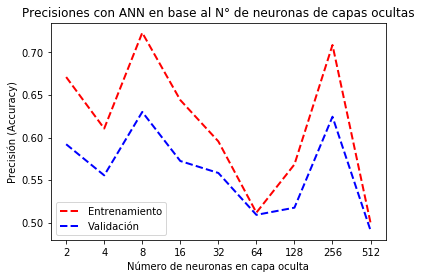

El mejor accuracy es 0.6300984530509273 cuando hay = 8 neuronas en capa oculta


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def do_ANN(x, y, xv, yv, param):
  #print("Neuron hidden = ",param)
  model = Sequential()
  model.add(Dense(units=param, input_dim=x.shape[1], activation="sigmoid"))
  model.add(Dense(1, activation="sigmoid"))
  model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
  model.fit(x, y, epochs=25, batch_size=128, verbose=0)
  train_acc = model.evaluate(x,y, verbose=0)[1] #in position 0 is the loss
  test_acc = model.evaluate(xv,yv, verbose=0)[1]

  return model, train_acc, test_acc

def ann_plot(p=10):
  N_h = [2**i for i in range(1, p)]
  train_accs = []
  test_accs = []
  max_val_acc = 0
  best_n = 0

  for n in N_h:
    model, train_acc, test_acc = do_ANN(features_train, labels_train, features_val, labels_val, n)    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc > max_val_acc:
      max_val_acc = test_acc
      best_n = n

  plt.plot(train_accs, marker='', color='red', linewidth=2, linestyle='dashed', label="Entrenamiento")
  plt.plot(test_accs, marker='', color='blue', linewidth=2, linestyle='dashed', label="Validación")
  plt.title("Precisiones con ANN en base al N° de neuronas de capas ocultas")
  xi = list(range(len(N_h)))
  plt.xticks(xi, N_h)
  plt.legend()
  plt.xlabel('Número de neuronas en capa oculta')
  plt.ylabel('Precisión (Accuracy)')
  plt.show()

  print("El mejor accuracy es {} cuando hay = {} neuronas en capa oculta".format(max_val_acc, best_n))

ann_plot()

**Comentarios:** Del gráfico anterior es posible notar un comportamiento irregular de las precisiones utilizando una Red Neuronal Artificial, donde se puede ver además que la precisión tiende a decrecer a medida que se aumenta la cantidad de neuronas en la capa oculta. Sin embargo, el máximo accuracy es de 0.630, lo que es un valor más aceptable en comparación a los otros modelos. La razón de este comportamiento depende netamente del dataset y de los atributos. Otra razón puede ser que utilizar muchas neuronas en la capa oculta no es eficiente para un problema de pocas clases, o de clasificación binaria.


> k) Ahora evalúe sobre el conjunto de pruebas el mejor modelo obtenido, seleccionado en base a la métrica de desempeño en el conjunto de validación. Comente sobre la calidad obtenida en el problema trabajado ¿Es un buen valor? ¿Cuál podría ser un valor de referencia?


In [18]:
model, train_acc, test_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = 10)

print("Score en el conjunto de pruebas: ",test_acc)

Score en el conjunto de pruebas:  0.7074542897327707


**Comentarios:**
El score anterior se obtuvo con el modelo de Regresión Logística con el mejor parámetro (C = 10). Es interesante notar que se obtuvo un valor similar que con el conjunto de validación, siendo que este último era utilizado para medir el overfitting de los modelos anteriores. En este caso, el sentido del score obtenido nos dice el poder predictivo real del modelo. En general es un buen valor, como es clasificación binaria se esperaría minimo obtener un 50%. Con el score obtenido el modelo tendrá un 70% de probabilidad para acertar.

Los métodos como Regresión Logística y SVM son buenos para el análisis de sentimiento, ya que estos pueden escalar bien en base al dataset; aunque independiente del método escogido, hay una gran importancia en la etapa del pre-procesamiento y vectorización donde pueden surgir ciertas incoherencias con la transformación de los textos.


> l) Para comparar sus resultados utilice el modelo VADER (*Valence Aware Dictionary and sEntiment Reasoner*) [[6]](#refs), el cual entrega una *score* de predicción a nivel léxico (de palabras que comúnmente se asocian a una orientiación positiva o negativa). Este modelo construido manualmente no requiere entrenamiento, por lo que solo debe evaluar en conjunto de pruebas realizando predicciones del texto bruto (sin pre-procesamiento). Comente.



In [20]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from sklearn.metrics import accuracy_score

def vader_predict(sentences): 
    sid_obj = SentimentIntensityAnalyzer() 
    sent_v = []

    for text in sentences:
        sentiment_dict = sid_obj.polarity_scores(text) 
        if sentiment_dict["pos"] > sentiment_dict["neg"]: #based on scores
            sent_v.append(1)
        else:
            sent_v.append(0)

    return np.asarray(sent_v)

vader_pred_test = vader_predict(df_test_text) 
accuracy_score(labels_test, vader_pred_test)

0.6359032076533483

**Comentarios:** Es interesante notar que el score entregado por el modelo VADER sea menor al obtenido por el mejor modelo. Una razón de esto se debe a la forma con la que VADER realiza las predicciones y que está entrenado para predecir polaridades en comentarios de redes sociales; por ende, el léxico utilizado para este trabajo puede no ser el más adecuado. Sin embargo, un score de 0.636 es un valor aceptable para respaldar la calidad de nuestro mejor modelo.


> m) Bajo la idea del modelo VADER realice un análisis de qué palabras su modelo tiende a considerar como positivas o negativas por si solas. Algunos de los modelos estudiados en esta sección realizan una predicción probabilista, utilice uno de éstos para verificar lo solicitado. Sobre la representación *TF* genere datos de entradas que contengan una sola palabra del vocabulario para evaluar que predicción les genera su modelo a esas palabras. Muestre las palabras más negativas y positivas en el vocabulario consideradas por su modelo. Comente.



In [21]:
def pos_vs_neg_words(vocab, model):
  V = len(vocab)
  word_scores = np.zeros((V, 2))

  for i in range(V):
    x_word = np.zeros((1, V))
    x_word[:,i] = 1 # only the "i" word appeared
    word_scores[i] = model.predict_proba(x_word)

  negative_scores = word_scores[:, 0]
  positive_scores = word_scores[:, 1]

  negative_indexes = negative_scores.argsort()[-20:][::-1]
  positive_indexes = positive_scores.argsort()[-20:][::-1]

  most_negative_words = [vocab[i] for i in negative_indexes]
  most_positive_words = [vocab[i] for i in positive_indexes]

  print("Top 20 palabras más positivas y negativas")
  print("-----------------------------------------")
  df_results = pd.DataFrame(list(zip(most_positive_words, most_negative_words)), 
                columns =['Positivas', 'Negativas']) 
  return df_results 

model, train_acc, test_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = 10)
pos_vs_neg_words(vocab, model)

Top 20 palabras más positivas y negativas
-----------------------------------------


,Positivas,Negativas
0,world,worst
1,marvel,cliche
2,witty,boring
3,wonderful,dull
4,solid,nearly
5,rare,feel
6,still,devoid
7,skillful,suffer
8,stick,pretentious
9,heart,apparent


**Comentarios:** Para obtener las 20 palabras principales de cada caso, se consideraron aquellas que solo tienen un score mayor a $0.9$. Se puede observar cierta lógica con la clasificación de las palabras según el modelo utilizado. Como son palabras que están solas en el texto, carecen de contexto, lo que implica que estas palabras de por sí se reconocer como positivas o negativas. Por ejemplo, las palabras como *wonderful*, *tasty* y *witty* son palabras bien clasificadas, mientras hay otros adjetivos que dificilmente se puedan clasificar como algo bueno o malo, como lo es en el caso de *ride*, *finish* y *culture*. Por otra parte, en las palabras negativas se puede identificar varias logicamente válidas sin necesidad de contexto, como son *boring*, *dull* o *bad*. Al igual que en las positivas, también hay adjetivos que no identifican algún sentimiento.


> n) Intente mejorar los resultados de otra manera. Varíe el pre-procesamiento realizado a los datos en c), por ejemplo eliminar símbolos, números o aplicar la técnica de *stemmming* [[7]](#refs) en lugar de *lemmatization* para llevar a su tronco léxico.


In [22]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

porter=PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    #token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

texts_train = [stemSentence(text) for text in df_train_text]
texts_val = [stemSentence(text) for text in df_val_text]
texts_test = [stemSentence(text) for text in df_test_text]

vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation

vectorizer.fit(texts_train)
features_train = vectorizer.transform(texts_train)
features_val = vectorizer.transform(texts_val)
features_test = vectorizer.transform(texts_test)
vocab = vectorizer.get_feature_names()

model, train_acc, test_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = 10)
pos_vs_neg_words(vocab, model)

C:\Users\Seba\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Top 20 palabras más positivas y negativas
-----------------------------------------


,Positivas,Negativas
0,marvel,suffer
1,world,appar
2,open,worst
3,flaw,bore
4,witti,clich
5,solid,dull
6,refreshingli,unfortun
7,alway,tv
8,warm,plod
9,tasti,pretenti


**Comentarios:** En este caso las palabras están reducidas a su raíz, por ejemplo, "tasty" cambió a "tasti". 

En general los resultados son similares al caso anterior.



> o) Varíe la representación utilizada actualmente por alguna otra que ayude a mejorar el desempeño, por ejemplo reducir el peso de una palabra si es que aparece en muchos textos: TF-IDF. Existen varias opciones que podría realizar para mejorar el desempeño, por ejemplo reducir el vocabulario a las $K$ palabras más frecuentes, eliminar las palabras menos frecuentes, normalizar la representación, utilizar *n-gramas*, entre otras.



In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Método 1: TF-IDF
tfidf_model = TfidfVectorizer(binary=False, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, norm='l2', use_idf=True, sublinear_tf=False)
tfidf_model.fit(texts_train)

new_features_train = tfidf_model.transform(texts_train)
new_features_val = tfidf_model.transform(texts_val)
new_features_test = tfidf_model.transform(texts_test)
new_vocab = tfidf_model.get_feature_names()

model, train_acc, test_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = 10)
pos_vs_neg_words(new_vocab, model)

C:\Users\Seba\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Top 20 palabras más positivas y negativas
-----------------------------------------


,Positivas,Negativas
0,marvel,suffer
1,world,appar
2,open,worst
3,flaw,bore
4,witti,clich
5,solid,dull
6,refreshingli,unfortun
7,alway,tv
8,warm,plod
9,tasti,pretenti


**Comentarios:** Los resultados son similares a los casos anteriores.


> p) Utilice métricas auxiliares para entender en qué falla su mejor modelo obtenido hasta el momento. ¿La información entregada indica cómo se podría mejorar o cual sería la causa de la falla?


In [24]:
from sklearn.metrics import classification_report

def score_the_model(model, x, y):
    print("Detailed Analysis Testing Results ...")
    print(classification_report(y, model.predict(x), target_names=['-','+']))

score_the_model(model, features_test, labels_test)

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.74      0.72      0.73      1803
           +       0.72      0.74      0.73      1751

    accuracy                           0.73      3554
   macro avg       0.73      0.73      0.73      3554
weighted avg       0.73      0.73      0.73      3554



**Comentarios:**
Se puede ver que la clasificación tiene una mayor precision en los comentarios negativos con un 0.74 vs un 0.72, mientras que el recall es mejor en los comentarios positivos, esto corresponder a la capacidad del modelo de encontrar las muestras positivas. Ahora si se ponderan ambas métricas (f1-score) se puede ver que el valor de ambos es igualmente bueno 0.73.
Al entregar solamente métricas no hay  indicaciones claras de como mejorar los resultados.

> q) Algo que se puede modificar en algunos modelos de aprendizaje es poner peso en cada una de las clases, por ejemplo si una clase es de mayor interés que las otras e interesa reducir más su error. En *sklearn* ésto puede ser realizado con el parámetro de *class_weights*. Por ejemplo, asigne que detectar los textos negativos me interesa 5 veces más que detectar los textos positivos. Comente.
```python
classes_weights = {0: 5, 1: 1} #or choose..
model.set_params(class_weight=classes_weights)
model.fit(features_train, labels_train)
score_the_model(model, features_test, labels_test)
```

In [25]:
classes_weights = {0: 5, 1: 1} #or choose..
model.set_params(class_weight=classes_weights)
model.fit(features_train, labels_train)
score_the_model(model, features_test, labels_test)
model.fit(new_features_train, labels_train)
score_the_model(model, new_features_test, labels_test)

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.71      0.79      0.75      1803
           +       0.76      0.67      0.71      1751

    accuracy                           0.73      3554
   macro avg       0.73      0.73      0.73      3554
weighted avg       0.73      0.73      0.73      3554

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.68      0.86      0.76      1803
           +       0.80      0.59      0.68      1751

    accuracy                           0.72      3554
   macro avg       0.74      0.72      0.72      3554
weighted avg       0.74      0.72      0.72      3554



C:\Users\Seba\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


En este item se le dio 5 veces más importancia a la detección de comentarios negativos por sobre la de los positivos


> r) Visualice la clasificación que realiza su mejor modelo sobre algunos textos de pruebas ¿Qué entega mas información, una predicción categórica o una continua? ¿Cuál podría ser el beneficio de una o de otra? Comente
```python
test_pred = log_model.predict_proba(features_test) #or ".predict"
spl = np.random.randint( 0, len(test_pred), size=15)
for text, pred_s, true_s in zip(df_test_text[spl], test_pred[spl], labels_test[spl]):
    print("True sent: ", true_s, "-- Pred sent: ",pred_s)
    print("Raw text: ", text)
```

In [26]:
#test_pred = log_model.predict_proba(features_test) #or ".predict"
test_pred = model.predict_proba(features_test) #or ".predict"
spl = np.random.randint(0, len(test_pred), size=15)

for text, pred_s, true_s in zip(df_test_text[spl], test_pred[spl], labels_test[spl]):
    print("True sent: ", true_s, "-- Pred sent: ",pred_s)
    print("Raw text: ", text)

True sent:  0.0 -- Pred sent:  [8.09415125e-08 9.99999919e-01]
Raw text:  handled correctly , wilde's play is a masterpiece of elegant wit and artifice . here , alas , it collapses like an overcooked soufflé .

True sent:  0.0 -- Pred sent:  [9.99986141e-01 1.38593711e-05]
Raw text:  a boring masquerade ball where normally good actors , even kingsley , are made to look bad .

True sent:  0.0 -- Pred sent:  [0.99474157 0.00525843]
Raw text:  it's better suited for the history or biography channel , but there's no arguing the tone of the movie - it leaves a bad taste in your mouth and questions on your mind .

True sent:  1.0 -- Pred sent:  [0.98087505 0.01912495]
Raw text:  daily struggles and simple pleasures usurp the preaching message so that , by the time the credits roll across the pat ending , a warm , fuzzy feeling prevails .

True sent:  0.0 -- Pred sent:  [0.72318589 0.27681411]
Raw text:  thriller directorial debut for traffic scribe gaghan has all the right parts , but the pi

**Comentarios**: Consideramos que las predicciones continuas entregan mejor información que las categóricas, ya que una prediccion categórica son más "extremista", pues solo considera que un comentario es bueno o malo, sin embargo en la vida real las cosas no son asi, en un mismo comentario podemos encontrar sentencias positivas y sentencias negativas. Es por esto que para hacer una análisis de los resultados quizás es mas conveniente usar la predicción continua, pero para el modelo es mejor la categorica.


> s) Comente sobre el desempeño obtenido por los diferentes modelos de aprendizaje utilizados al enfrentar el problema, ¿Dónde pareciera estar la mejora? ¿En la variación de los modelos y sus parámetros o en la modificación de la representación? ¿Cuál modelo de aprendizaje le parece mejor en base a su criterio? ya sea desempeño, tiempo de ejecución comodidad en las decisiones involucradas, etc.

**Comentarios**:En general el desempeño obtenido por los diferentes modelos de aprendizaje supervisado son todos aceptables con algunas diferencias. Ciertos modelos se adecuan mejor al caso, tales como, la regresión logistica y SVM (estos son los que tienen mejor accuracy);al ser escalables, mientras más datos se les entregan mejor podría ser el resultado. 

Lo más importante en el desempeño de los diferentes modelos puede considerarse en el siguiente orden, primero la elección del modelo, luego la selección de los parámetros y finalmente la representación de los datos. Un buen modelo involucraría un correcto ajuste de parámetros, mientras que la representación en sí, es importante pero podría ser ineficiente si es que no se ha escogido el modelo correcto. Por ejemplo, el modelo de árbol de decisión, KNN y redes neuronales daban buenos resultados pero requerian mayor tiempo de ejecución, probablemente porque son técnicas muy complejas para un problema de clasificación binaria (es matar una mosca con un cañon).

Consideramos que el mejor modelo es el de regresión logistica si consideramos la precisión, el tiempo de ejecución y comodidad para ajustar parámetros.

<a id="segundo"></a>
## 2. Problema de Múltiples Anotaciones

El aprendizaje supervisado visto en clases da cuenta que existe una única posible etiqueta $z$ (*ground truth*) asociada a un dato $x$ para poder aprender de los datos. Sin embargo, la definición del *ground truth* en algunos casos puede resultar bastante difícil de definir o bastante costoso, por ejemplo en problemas médicos donde se deben realizar invasivos exámenes para conocer la "verdad absoluta". Como alternativa se pueden recolectar múltiples anotaciones desde personas inexpertas en el área para poder estimar el *ground truth*. 

<img src="http://www.irishenvironment.com/wp-content/uploads/2013/11/crowdsourcing.jpg" title="Title text" width="40%" />

En esta actividad se trabajará en el caso en que contamos con múltiples anotaciones por cada dato de entrada $x_i$ dadas por personas inexpertas a través de Amazon Mechanical Turk (__[AMT](https://www.mturk.com/)__), es decir, $y^{(1)}, y^{(2)} \ldots y^{(T_i)}$. El problema de predicción trabajado será el mismo de la actividad anterior, el análisis de sentimiento de un extracto de texto en Rotten Tomatoes. Los datos trabajados [[8]](#refs) pueden ser descargados de la página del autor.
```
wget http://fprodrigues.com//mturk-datasets.tar.gz
```

De esta manera trabajaremos con el archivo *mturk_answers.csv* en la carpeta *sentiment polarity* que se puede cargar con pandas. En este archivo se tendrán múltiples filas/registros por cada dato de entrenamiento, cada uno representando la etiqueta que entregó una persona (*worker*) a ese dato, los detalles de columnas son:
* *WorkerId*: identificador de la persona que etiquetó/anotó el dato
* *Input.id*: identificador del dato a etiquetar/anotar
* *Input.original_sentence*: texto original del dato
* *Input.stemmed_sent*: texto pre-procesado
* *Input.true_sent*: sentimiento real (*ground truth*) del dato
* *Answer.sent*:   etiqueta/anotación que entregó la persona

```python
import pandas as pd
df = pd.read_csv("./sentiment_polarity/mturk_answers.csv") 
```

> El objetivo de la actividad será el de obtener un modelo predictor del *ground truth* sin entrenar directamente con esto, sino que utilizar las múltiples anotaciones de las personas

### Importante
* Deberá crear un conjunto aleatorio de pruebas que solo contenga los textos y el sentimiento *ground truth* (sin repeticiones)
* Los valores de *ground truth* están **solo para evaluar**, no puede utilizarlos para entrenar o tomar decisiones en su modelo.
* La métrica de evaluación será el *accuracy score*
```python
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
```

#### Sugerencias
Para representar los textos, a diferencia de lo visto en la sección 1, se puede utilizar lo que son la representación vectorial de palabras (*word vectors*), a través de modelos especializados entrenados para aprender una representación en que palabras similares estén cercanas en el espacio vectorial. Puede utilizar los vectores livianos de __[GLOVE](https://nlp.stanford.edu/projects/glove/)__ en su versión entradas en textos de Wikipedia con 6 billones de palabras/tokens.
```python
EMBEDDING_DIM = 300
GLOVE_FILE = "./glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
...
embeddings_index.get(word)
```
> Para descargar GLOVE
```
wget http://nlp.stanford.edu/data/glove.6B.zip
```

Antes de empezar, hay que descargar y descomprimir los dataset. Luego hay que abrir los archivos y hacer la respectiva separación de conjuntos. En este caso se usa 70% de los datos para entrenamiento y el otro 30% para pruebas; éste último contiene los ground truth verdaderos y solo serán utilizados para evaluar.

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Dataset: Lectura de archivo.
df = pd.read_csv("./mturk_answers.csv") 

# Obtención de elementos
original_sentences = [text for text in df['Input.original_sentence']]
stemmed_sentences = [stemmed_text for stemmed_text in df['Input.stemmed_sent']]
annotations = [annotation for annotation in df['Answer.sent']]
ground_truths = [sentiment for sentiment in df['Input.true_sent']]

# Separación de conjuntos
# Conjuntos de entrenamiento y prueba con anotaciones
train_text, test_text, annotations_train, annotations_test = train_test_split(stemmed_sentences, annotations, test_size=0.30, random_state=0)

# Conjuntos de prueba y entrenamiento con ground_truths (solo usar para validar)
gts_train, gts_test = train_test_split(ground_truths, test_size=0.30, random_state=0)

Una ventaja del dataset entregado es que a los textos ya se les aplicó stemming, por lo que el pre-procesamiento ya está listo y basta con vectorizarlos. En este caso se utilizará TF-IDF.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizador (TF-IDF)
tfidf_model = TfidfVectorizer(binary=False, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, norm='l2', use_idf=True, sublinear_tf=False)
tfidf_model.fit(train_text)

new_features_train = tfidf_model.transform(train_text) # TD-IDF para datos con anotaciones.
new_features_test = tfidf_model.transform(test_text)  # TD-IDF para datos con valores reales.

El objetivo de la propuesta es la siguiente: Se entrenarán los modelos vistos en la sección 1 de la tarea y se hará una clasificación mediante votación. Cada uno de ellos recibirán los textos vectorizados de entrenamiento y sus respectivas anotaciones. Para determinar cuál es el ground truth se realizará un meta-ensamblado, es decir, una técnica que combina las predicciones de los modelos anteriores para generar un nuevo modelo que supera a todos los anteriores. 

Primero es necesario definir los módelos que se utilizarán.





In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.svm import SVC as SVM
from sklearn.ensemble import VotingClassifier

# Modelos
# Regresión Logística
clf1 = LogisticRegression()

# KNN
clf2 = KNeighborsClassifier()
clf2.set_params(n_neighbors = 431)

# Árbol de Decisión
clf3 = Tree()
clf3.set_params(max_depth = 3081, min_samples_split = 712) 

# SVM
clf4 = SVM()
clf4.set_params(C=10, kernel='sigmoid')

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

La elección de la etiqueta adecuada se realizará mediante *Hard Voting* y *Soft Voting*. 

Hard Voting consiste en elegir la etiqueta más repetida predecida por los módelos; en este caso se utilizarán Regresión Logística, KNN, Árbol de Decisión y SVM. Como no se puede utilizar el conjunto de prueba es complicado encontrar los parámetros adecuados para mejorar la calidad de la predicción final, por tanto, se utilizarán los parámetros que maximizan el score en la sección 1 de la tarea.

In [32]:
# Voting Classifier: Hard Majority Voting. Se elige la etiqueta más repetida.
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('knn', clf2), ('tree', clf3), ('svm', clf4)], voting='hard')
eclf1 = eclf1.fit(new_features_train, annotations_train)

y_pred_hard = eclf1.predict(new_features_test)

Por otra parte se utilizará Soft Voting, que a diferencia del Hard Voting, los modelos entregarán las probabilidades de cada etiqueta y que luego serán promediadas para determinar cuál es la mejor. No debiese ser muy distinto que el Hard Voting, pues al final se convierte en un problema de clasificación binaria.

Para Soft Voting no se utilizará SVM porque no permite entregar las probabilidades.

In [33]:
# Voting Classifier: Soft Majority Voting. Se elije la etiqueta con mayor probabilidad.
eclf2 = VotingClassifier(estimators=[('lr', clf1), ('knn', clf2), ('tree', clf3)], voting='soft')
eclf2 = eclf2.fit(new_features_train, annotations_train)
y_pred_soft = eclf2.predict(new_features_test)

Finalmente, los resultados son:

In [34]:
print("Score con Hard Voting: ", accuracy_score(gts_test, y_pred_hard))
print("Score con Soft Voting: ", accuracy_score(gts_test, y_pred_soft))

Score con Hard Voting:  0.8301297453147525
Score con Soft Voting:  0.7984142239308025


Los scores obtenidos son aceptables para una clasificación binaria. Sin embargo, aún no es posible decidir si el modelo sufre de overfitting; existe un riesgo para esto y es que los modelos recibieron datos parcialmente *duplicados*, es decir, mismos textos para distintas anotaciones.

<a id="refs"></a>
# Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews  
[3] https://en.wikipedia.org/wiki/Stopwords  
[4] https://en.wikipedia.org/wiki/Lemmatisation  
[5] Landauer, T. K., Foltz, P. W., & Laham, D. (1998). *An introduction to latent semantic analysis*. Discourse processes, 25(2-3), 259-284.  
[6] https://github.com/cjhutto/vaderSentiment  
[7] https://en.wikipedia.org/wiki/Stemming  
[8] Rodrigues, F., Pereira, F., & Ribeiro, B. (2013). *Learning from multiple annotators: distinguishing good from random labelers*. Pattern Recognition Letters, 34(12), 1428-1436.